# Lab 7 — TD(0) Temporal-Difference Learning

**Goals:**

- Implement TD(0) for state-value prediction (bootstrapping).
- Compare TD(0) with Monte Carlo and Iterative Policy Evaluation (DP).
- Add complexity: stochastic transitions and TD(0) with linear function approximation.
- Provide cell-by-cell explanation and many visualizations.

**Notes:** Run cells in order. The notebook is self-contained and uses a small GridWorld so it runs without external RL libraries.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import math
import nbformat

print('Libraries loaded')

Libraries loaded


## GridWorld Environment (Deterministic & Stochastic)

We define a GridWorld where the agent receives -1 per step and 0 at terminal. We'll include a stochastic transition option (slip probability) as added complexity.

In [2]:
class GridWorld:
    def __init__(self, width=5, height=5, start=(0,0), terminals=None, obstacles=None, slip=0.0):
        self.width = width
        self.height = height
        self.start = start
        self.agent = start
        # actions: Right, Down, Left, Up
        self.actions = [(1,0),(0,1),(-1,0),(0,-1)]
        self.action_names = ['R','D','L','U']
        self.terminals = set(terminals) if terminals else set()
        self.obstacles = set(obstacles) if obstacles else set()
        self.slip = slip  # probability of randomizing the intended action

    def reset(self):
        self.agent = self.start
        return self.agent

    def step(self, action):
        if self.agent in self.terminals:
            return self.agent, 0, True, {}
        # slip: with probability slip take random other action
        if random.random() < self.slip:
            action = random.randrange(len(self.actions))
        dx,dy = self.actions[action]
        nx = min(max(0, self.agent[0] + dx), self.width-1)
        ny = min(max(0, self.agent[1] + dy), self.height-1)
        if (nx,ny) in self.obstacles:
            nx,ny = self.agent
        self.agent = (nx,ny)
        reward = -1
        done = self.agent in self.terminals
        if done:
            reward = 0
        return self.agent, reward, done, {}

    def state_space(self):
        states = []
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) not in self.obstacles:
                    states.append((x,y))
        return states

    def render_values(self, values, title='Value function'):
        grid = np.full((self.width, self.height), np.nan)
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) in self.obstacles:
                    grid[x,y] = np.nan
                else:
                    grid[x,y] = values.get((x,y), 0)
        plt.figure(figsize=(6,5))
        sns.heatmap(grid.T[::-1], annot=True, fmt='.2f', cmap='viridis', cbar=True)
        plt.title(title)
        plt.show()

    def render_policy(self, policy, title='Policy'):
        grid = np.full((self.width, self.height), ' ')
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) in self.obstacles:
                    grid[x,y] = 'X'
                elif (x,y) in self.terminals:
                    grid[x,y] = 'T'
                else:
                    grid[x,y] = policy.get((x,y),' ') 
        print(title)
        for y in range(self.height-1, -1, -1):
            row = ''
            for x in range(self.width):
                row += f'{grid[x,y]:>4}'
            print(row)

print('GridWorld defined')

GridWorld defined


In [3]:
env = GridWorld(width=5, height=5, start=(0,0), terminals=[(4,4)], obstacles=[(1,1),(2,2)], slip=0.0)
states = env.state_space()
print('Num states:', len(states))
print('Terminals:', env.terminals)
print('Obstacles:', env.obstacles)
env.render_policy({}, title='Empty grid (T=terminal, X=obstacle)')

Num states: 23
Terminals: {(4, 4)}
Obstacles: {(1, 1), (2, 2)}
Empty grid (T=terminal, X=obstacle)
                   T
                    
           X        
       X            
                    


In [4]:
def state_to_index(s, width):
    return s[0] + s[1]*width

def index_to_state(i, width):
    return (i % width, i // width)

print('Helpers ready')

Helpers ready


## Policy Definition

We'll evaluate a **random policy** (uniform random actions) using TD(0). This is common for prediction exercises.

In [5]:
def random_policy(state, env):
    return random.randrange(len(env.actions))

# convenience: policy as dict mapping state->action (optional)
random_policy_dict = {}
for s in env.state_space():
    random_policy_dict[s] = None  # indicates random selection in code

print('Random policy ready')

Random policy ready


## Iterative Policy Evaluation (Dynamic Programming)

We compute the value function for the policy using iterative policy evaluation (backup using expected transitions). For deterministic grid and random policy this gives a reference 'true' value for comparison.

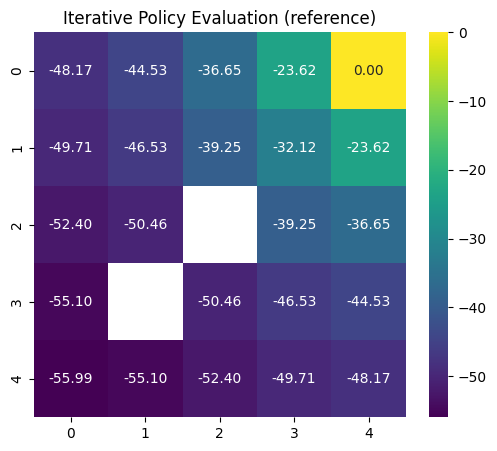

In [6]:
def iterative_policy_evaluation(env, policy, theta=1e-4, gamma=0.99):
    V = {s:0.0 for s in env.state_space()}
    while True:
        delta = 0
        for s in env.state_space():
            if s in env.terminals or s in env.obstacles:
                continue
            v = V[s]
            # under random policy, expected over actions and slip
            new_v = 0
            for a in range(len(env.actions)):
                # simulate expected next state under slip
                val = 0
                for actual_a in range(len(env.actions)):
                    # probability of actual_a: slip leads to uniform else intended
                    p = (env.slip / len(env.actions)) + (1 - env.slip) * (1.0/len(env.actions))
                    # here since policy is uniform, distribution collapses to uniform across actual actions
                    dx,dy = env.actions[actual_a]
                    nx = min(max(0, s[0] + dx), env.width-1)
                    ny = min(max(0, s[1] + dy), env.height-1)
                    if (nx,ny) in env.obstacles:
                        nx,ny = s
                    reward = -1
                    if (nx,ny) in env.terminals:
                        reward = 0
                    val += p * (reward + gamma * V[(nx,ny)])
                new_v += (1.0/len(env.actions)) * val
            V[s] = new_v
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

V_true = iterative_policy_evaluation(env, random_policy_dict, theta=1e-4)
env.render_values(V_true, title='Iterative Policy Evaluation (reference)')

## TD(0) — Temporal-Difference Prediction (Tabular)

Implement TD(0) for state-value estimation under the random policy. We will track RMSE against the reference value from DP.

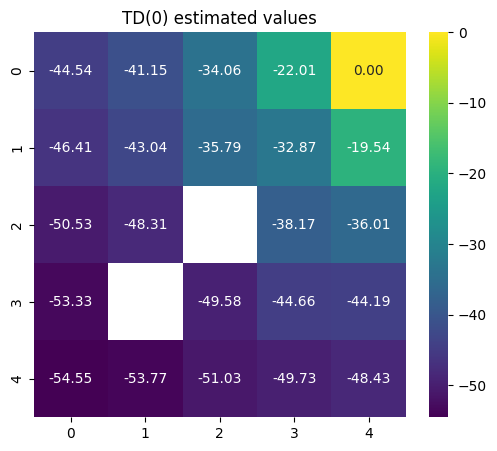

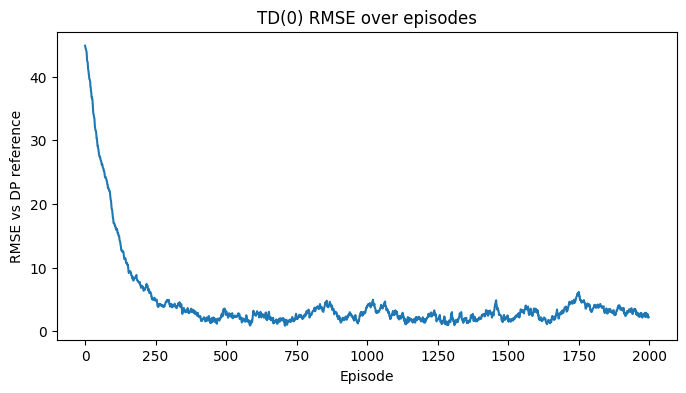

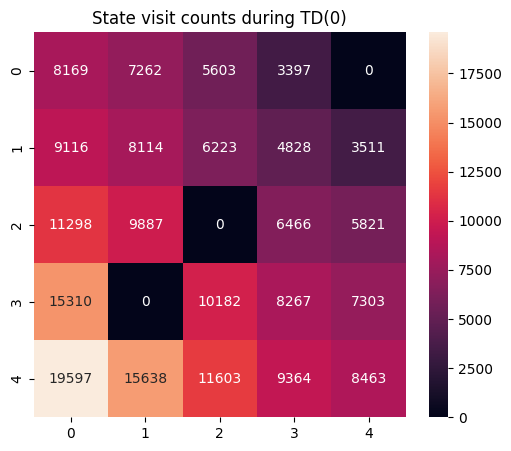

In [7]:
def td0_prediction(env, policy_fn, alpha=0.1, gamma=0.99, episodes=2000, max_steps=200, track_rmse=False, V_ref=None):
    V = defaultdict(float)
    rmse_history = []
    visit_counts = defaultdict(int)

    for ep in range(episodes):
        s = env.reset()
        for t in range(max_steps):
            a = policy_fn(s, env)
            s2, r, done, _ = env.step(a)
            visit_counts[s] += 1
            V[s] += alpha * (r + gamma * V[s2] - V[s])
            s = s2
            if done:
                break
        if track_rmse and V_ref is not None:
            # compute RMSE over non-obstacle states
            se = 0.0
            n=0
            for ss in env.state_space():
                if ss in env.obstacles or ss in env.terminals:
                    continue
                se += (V[ss] - V_ref.get(ss,0))**2
                n+=1
            rmse = math.sqrt(se/n) if n>0 else 0
            rmse_history.append(rmse)
    return V, rmse_history, visit_counts

V_td, rmse_hist, visits = td0_prediction(env, random_policy, alpha=0.1, episodes=2000, track_rmse=True, V_ref=V_true)

# visualize
env.render_values(V_td, title='TD(0) estimated values')

plt.figure(figsize=(8,4))
plt.plot(rmse_hist)
plt.xlabel('Episode')
plt.ylabel('RMSE vs DP reference')
plt.title('TD(0) RMSE over episodes')
plt.show()

# visits heatmap
visit_grid = np.zeros((env.width, env.height))
for x in range(env.width):
    for y in range(env.height):
        visit_grid[x,y] = visits.get((x,y),0)
plt.figure(figsize=(6,5))
sns.heatmap(visit_grid.T[::-1], annot=True, fmt='.0f')
plt.title('State visit counts during TD(0)')
plt.show()

## Monte Carlo (First-Visit) Baseline

We implement first-visit Monte Carlo to estimate state-values and compare RMSE with TD(0).

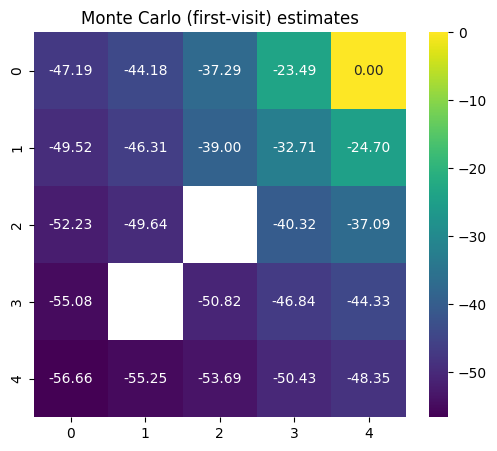

RMSE TD(0): 2.2261789873044178
RMSE MC   : 0.6094097961690946


In [8]:
def mc_first_visit(env, policy_fn, episodes=2000, gamma=0.99, max_steps=500):
    returns = defaultdict(list)
    for ep in range(episodes):
        s = env.reset()
        episode = []
        for t in range(max_steps):
            a = policy_fn(s, env)
            s2, r, done, _ = env.step(a)
            episode.append((s,r))
            s = s2
            if done:
                break
        G = 0
        for idx in range(len(episode)-1, -1, -1):
            s_t, r_t = episode[idx]
            G = gamma * G + r_t
            if s_t not in [x[0] for x in episode[:idx]]:  # first-visit
                returns[s_t].append(G)
    V = {s: np.mean(returns[s]) if len(returns[s])>0 else 0 for s in env.state_space()}
    return V

V_mc = mc_first_visit(env, random_policy, episodes=1000)
env.render_values(V_mc, title='Monte Carlo (first-visit) estimates')

# RMSE comparison
def compute_rmse(V_est, V_ref, env):
    se=0.0; n=0
    for s in env.state_space():
        if s in env.obstacles or s in env.terminals: continue
        se += (V_est.get(s,0) - V_ref.get(s,0))**2
        n+=1
    return math.sqrt(se/n) if n>0 else 0

print('RMSE TD(0):', compute_rmse(V_td, V_true, env))
print('RMSE MC   :', compute_rmse(V_mc, V_true, env))

## Experiment: Effect of Learning Rate (α)

Run TD(0) for different α values and plot RMSE curves to study stability and convergence speed.

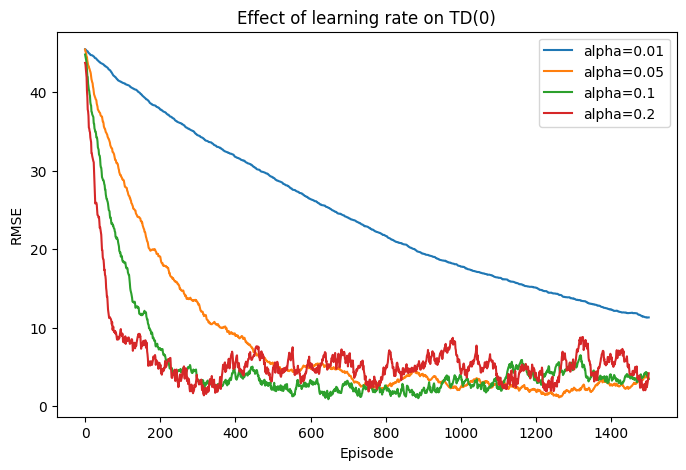

In [9]:
alphas = [0.01, 0.05, 0.1, 0.2]
rmse_runs = {}
for a in alphas:
    Vtmp, rmse_tmp, _ = td0_prediction(env, random_policy, alpha=a, episodes=1500, track_rmse=True, V_ref=V_true)
    rmse_runs[a] = rmse_tmp

plt.figure(figsize=(8,5))
for a, r in rmse_runs.items():
    plt.plot(r, label=f'alpha={a}')
plt.xlabel('Episode')
plt.ylabel('RMSE')
plt.legend()
plt.title('Effect of learning rate on TD(0)')
plt.show()

## Added Complexity 1 — Stochastic Transitions

We enable slip (random action) and run TD(0) again to see how stochasticity affects learning.

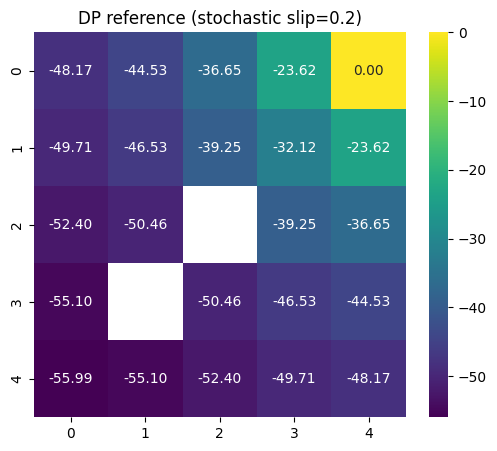

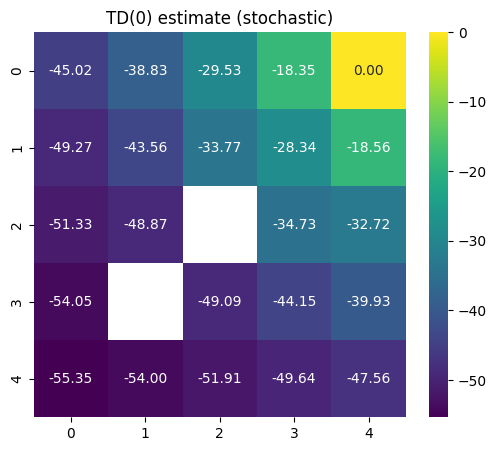

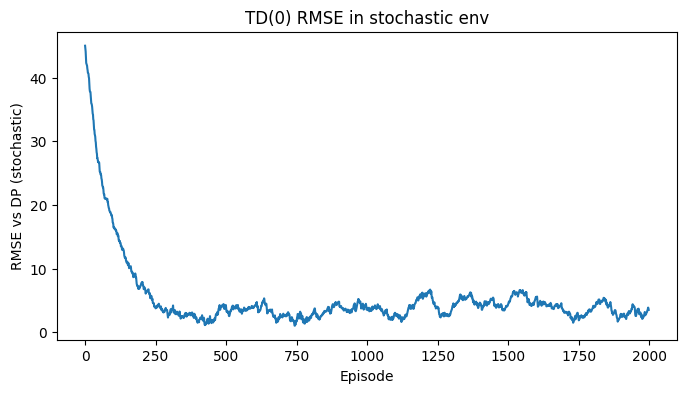

In [10]:
env_stoch = GridWorld(width=5, height=5, start=(0,0), terminals=[(4,4)], obstacles=[(1,1),(2,2)], slip=0.2)
V_true_stoch = iterative_policy_evaluation(env_stoch, random_policy_dict, theta=1e-4)
V_td_stoch, rmse_s, visits_s = td0_prediction(env_stoch, random_policy, alpha=0.1, episodes=2000, track_rmse=True, V_ref=V_true_stoch)

env_stoch.render_values(V_true_stoch, title='DP reference (stochastic slip=0.2)')
env_stoch.render_values(V_td_stoch, title='TD(0) estimate (stochastic)')

plt.figure(figsize=(8,4))
plt.plot(rmse_s)
plt.xlabel('Episode')
plt.ylabel('RMSE vs DP (stochastic)')
plt.title('TD(0) RMSE in stochastic env')
plt.show()

## Added Complexity 2 — TD(0) with Linear Function Approximation

We featurize states (x, y, x*y, bias) and learn weights using TD(0) updates. This allows generalization across states.

Learned weights: [  0.66574244   0.5929324    1.23683548 -97.36765364]


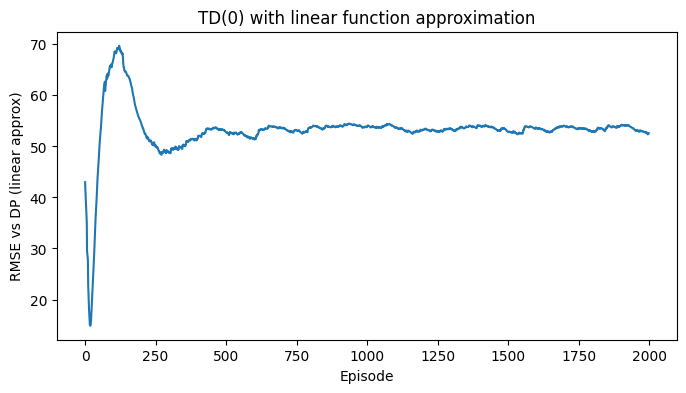

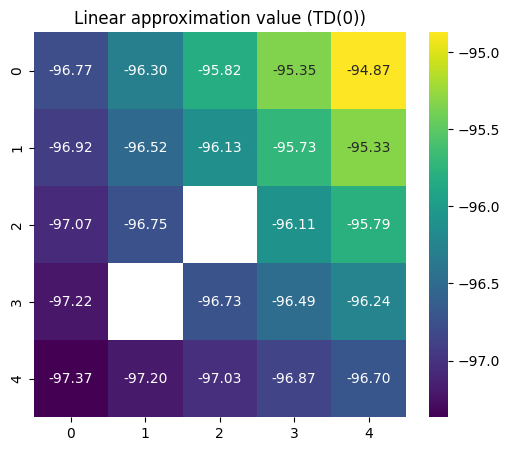

In [11]:
def featurize(s, env):
    # normalized coordinates + interaction term + bias
    return np.array([s[0]/(env.width-1), s[1]/(env.height-1), (s[0]*s[1])/((env.width-1)*(env.height-1)), 1.0])

def td0_linear(env, policy_fn, alpha=0.01, gamma=0.99, episodes=3000):
    n = 4
    w = np.zeros(n)
    rmse_hist = []
    for ep in range(episodes):
        s = env.reset()
        done = False
        while not done:
            a = policy_fn(s, env)
            s2, r, done, _ = env.step(a)
            x = featurize(s, env)
            x2 = featurize(s2, env)
            v = w.dot(x)
            v2 = w.dot(x2)
            td_err = r + gamma * v2 - v
            w += alpha * td_err * x
            s = s2
        # compute RMSE vs DP reference on this env's feature mapping
        se=0.0; nstates=0
        for ss in env.state_space():
            if ss in env.obstacles or ss in env.terminals: continue
            se += (w.dot(featurize(ss, env)) - V_true.get(ss,0))**2
            nstates+=1
        rmse_hist.append(math.sqrt(se/nstates))
    return w, rmse_hist

w, rmse_lin = td0_linear(env, random_policy, alpha=0.02, episodes=2000)
print('Learned weights:', w)

plt.figure(figsize=(8,4))
plt.plot(rmse_lin)
plt.xlabel('Episode')
plt.ylabel('RMSE vs DP (linear approx)')
plt.title('TD(0) with linear function approximation')
plt.show()

# value surface from weights
V_approx = {s: w.dot(featurize(s, env)) for s in env.state_space()}
env.render_values(V_approx, title='Linear approximation value (TD(0))')

## Summary & Extra Complexity Added

**Main implementation:**
- TD(0) tabular prediction under a random policy.
- Comparison to Monte Carlo (first-visit) and Iterative Policy Evaluation (DP) as reference.

**Complexity added:**
1. **Stochastic transitions (slip)** — shows how TD(0) behaves with nondeterministic dynamics.
2. **TD(0) with linear function approximation** — demonstrates generalization and weight learning.

You can tweak hyperparameters (α, γ), the grid size, slip probability, or feature design to explore further.

---

The notebook has been saved to `/mnt/data/rl_lab7_td0.ipynb`. Download it using the link below.
